In [1]:
import numpy as np
import matplotlib.pyplot as plt
import vegas
from constants import *

In [2]:
from geometry import get_rprime,get_d,get_D,get_cosPsi
from crossSection import get_BDMv,get_BDMp,diffCrossSectionNuDM,get_Ev_cosPhi

In [16]:
def dnv(D,Ev,Lv = Lv,tau = 10):
    """
    Neutrino number density per energy at d
    
    Input
    ------
    Enu: Neutrino energy in MeV
    D: Distance from the boosted point to the SN explosion site, in kpc
    Lv: Neutrino luminosity, default is 1e52 erg/s
    tau: duration of the SN explosion
    
    Output
    ------
    Neutrino flux at d: # per Enu per cm**3
    """
    Lv = Lv*erg2MeV*tau
    D = D*kpc2cm
    
    # Fermi dirac distribution
    def _fv(Ev,Tv):
        exponent = Ev/Tv - 3
        return (1/18.9686)*Tv**(-3)*(Ev**2/(np.exp(exponent) + 1))
    
    nue_dist = _fv(Ev,2.76)/11
    nueb_dist = _fv(Ev,4.01)/16
    # total 4 species for x
    nux_dist = _fv(Ev,6.26)/25
    
    luminosity = Lv/(4*np.pi*D**2*light_speed)
    return luminosity*(nue_dist+nueb_dist+4*nux_dist)


def nx(r,mx):
    """
    DM halo number density at r in MW
    
    Input
    ------
    r: distance to GC, in kpc
    mx: DM mass in MeV
    
    Output
    ------
    DM number density, #/cm^3 at r
    """
    rr=r/24.42
    return (184/mx)/(rr*(1 + rr)**2)

The term $dE_\nu/dT_\chi$ can be evaluated through the reciprocal of
$$
\frac{dT_\chi}{dE_\nu} = \frac{d}{dE_\nu}\left( E_\nu - \frac{E_\nu m_\chi}{m_\chi + E_\nu(1-\cos\phi)}\right)
$$
where
$$
\cos\phi = \frac{1}{\sqrt{1+\frac{\sin^2\psi}{(E_\nu/p_\chi -\cos\psi)^2}}}.
$$
We solved this with 
$$
\frac{d T_\chi}{dE_\nu}=1+\frac{E_{\nu}m_{\chi}}{[m_{\chi}+E_{\nu}(1-1/\sqrt{\xi})]^{2}}\left[1-\frac{E_{\nu}\sin^{2}\psi}{p_{\chi}(\frac{E_{\nu}}{p_{\chi}}-\cos\psi)^{3}\xi^{3/2}}-\frac{1}{\sqrt{\xi}}\right]-\frac{m_{\chi}}{m_{\chi}+E_{\nu}(1-1/\sqrt{\xi})}
$$
where
$$
\xi = 1+\frac{\sin^2\psi}{(E_\nu/p_\chi -\cos\psi)^2}
$$

In [12]:
def get_Ev(Tx,mx,alpha):
    """
    Calculate the neutrino energy to produce DM kinetic energy at
    lab frame with scattering angle alpha via analytical expression.
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    
    Output
    Ev: the corresponding neutrino energy
    """ 
    sec = 1/np.cos(alpha)
    Enu = (Tx*sec**2+sec*np.sqrt(Tx*(2*mx+Tx)))/(2-Tx*np.tan(alpha)**2/mx)
    return Enu

def gamma(Ev,mx):
    """
    Calculate gamma factor in CM frame
    """
    s = mx**2+2*Ev*mx
    Ecm = 0.5*(s+mx**2)/np.sqrt(s)
    return Ecm/mx


def g(Ev,mx,alpha):
    """
    Calculate BDM angular distribution dndOmega
    
    Input
    ------
    Enu: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    g: PDF of scattering angle alpha
    """ 
    if 0 <= alpha <= np.pi/2 and Ev > 0:
        gm = gamma(Ev,mx)
        sec = 1/np.cos(alpha)
        dndOmega = gm**2*sec**3/np.pi/(1+gm**2*np.tan(alpha)**2)**2
    else:
        dndOmega = 0
    return dndOmega

def dEv_legacy(Tx,mx,alpha):
    """
    Calculate dEv/dTx via analytical expression. Note that the given
    inputs must lead to positive Ev or the corresponding dEvdTx would
    be unphysical
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    
    Output
    ------
    dEv/dTx: the derivative of Ev over Tx
    """
    sec = 1/np.cos(alpha)
    numerator = mx**2*sec*(2*sec*np.sqrt(Tx*(2*mx + Tx)) + 2*mx + Tx*sec**2 + Tx)
    denominator = (Tx*np.tan(alpha)**2 - 2*mx)**2*np.sqrt(Tx*(2*mx + Tx))
    return numerator/denominator


In [61]:
def dEv(Ev,Tx,mx,psi):
    """
    Get the dEv/dTx for the given inputs
    """
    px = get_BDMp(Tx,mx)
    xi = 1 + np.sin(psi)**2/(Ev/px - np.cos(psi))**2
    A = Ev*mx/(mx + Ev*(1 - 1/np.sqrt(xi)))**2
    B = 1 - Ev*np.sin(psi)**2/px/(Ev/px - np.cos(psi))**3/xi**1.5 - 1/np.sqrt(xi)
    C = mx/(mx + Ev*(1 - 1/np.sqrt(xi)))
    dTxdEv = 1 + A*B - C
    return 1/dTxdEv


def xemissivity(Tx,mx,mV,r,D,Rstar,psi,Re = 8.5,gV = 1,gD = 1,max_Ev = 100,deltaTx = 1e-6,tau = 10):
    """
    Evaluate the BDM emissivity toward the direction psi at the given boosted point 
    
    Input
    ------
    Tx: BDM kinetic energy, MeV
    mx: DM mass, MeV
    mV: mediator mass, MeV
    r: distance from boosted point to GC for calculating DM number density, kpc
    D: distance from boosted point to the SN explosion site, kpc
    Rstar: distance from SN to the Earth, kpc
    psi: the BDM scattering angle, rad
    Re: distance from GC to Earth, default 8.5 kpc
    gV: DM-neutrino coupling constant, default 1
    gD: DM-DM coupling constant, default 1
    max_Ev: maximum neutrino energy to be searched for, default 100 MeV
    
    Output
    ------
    jx: BDM emissivity at the boosted point, 1/(MeV*cm^3*s*rad)
    """
    # Get the required Ev and cos(phi) to generate BDM with kinetic energy Tx with DM
    # scattering angle psi
    Ev,cosPhi,flag,_ = get_Ev_cosPhi(Tx,mx,psi,max_Ev = max_Ev)
    Evp,_,flag_dTx,_ = get_Ev_cosPhi(Tx + deltaTx,mx,psi,max_Ev = 100*max_Ev)
    # If both flags are valid, proceed the calculation. Otherwise, terminates the function 
    if flag == 'valid' and flag_dTx == 'valid':
        # Get the differential DM-nu scattering cross section
        diffCrox = diffCrossSectionNuDM(cosPhi,Ev,mx,mV,gV,gD)
        # Get dEv/dTx
        dEvdTx = (Evp - Ev)/deltaTx # dEv(Ev,Tx,mx,psi) # 
        # Get the emissivity jx
        jx = light_speed*diffCrox*nx(r,mx)*dnv(D,Ev,Lv,tau)*dEvdTx
        return jx
    else:
        # flag is invalid, unphysical inputs
        return 0
    

def xemissivity_legacy(Tx,mx,r,D,Rstar,psi,sigxv = 1e-45,Re = 8.5,max_Ev = 100,tau = 10):
    """
    Evaluate the BDM emissivity toward the direction psi at the given boosted point 
    (legacy version)
    
    Input
    ------
    Tx: BDM kinetic energy, MeV
    mx: DM mass, MeV
    r: distance from boosted point to GC for calculating DM number density, kpc
    D: distance from boosted point to the SN explosion site, kpc
    Rstar: distance from SN to the Earth, kpc
    psi: the BDM scattering angle, rad
    Re: distance from GC to Earth, default 8.5 kpc
    max_Ev: maximum neutrino energy to be searched for, default 100 MeV
    
    Output
    ------
    jx: BDM emissivity at the boosted point, 1/(MeV*cm^3*s*rad)
    """
    Ev = get_Ev(Tx,mx,psi)
    if Tx < 2*mx/np.tan(psi)**2:
        # Get dEv/dTx
        dEvdTx =  dEv_legacy(Tx,mx,psi)
        # Get the emissivity jx
        jx = light_speed*sigxv*nx(r,mx)*dnv(D,Ev,Lv,tau)*dEvdTx
        return jx
    else:
        # flag is invalid, unphysical inputs
        return 0
        

In [71]:
get_Ev_cosPhi(0.1,1e-3,0)

(nan, nan, 'invalid', 3)

In [62]:
get_Ev_cosPhi(5,1e-3,0.1),get_Ev_cosPhi(5-1e-4,1e-3,0.1)

((5.001052503258818, 0.05008413487069898, 'valid', 1),
 (5.000952503256714, 0.05008413696940668, 'valid', 1))

In [30]:
(Evp-Ev)/1e-4

1.0000000210386162

In [90]:
get_BDMv(5,1e-3)

0.9999999800079973

In [43]:
dEvdTx(5,Evp,1e-3,0.1)

1.0021967448378222

In [52]:
def get_BDMflux_theta(t,Tx,mx,mV,Rstar,theta,phi,beta,Re = 8.5,gV = 1,gD = 1,max_Ev = 100,tau = 10):
    # Get BDM velocity
    vx = get_BDMv(Tx,mx)
    # Get the propagation length of BDM via given t and vx
    d = get_d(t,vx,Rstar,theta)
    # Get the required SNv propagation length
    D = get_D(d,Rstar,theta)
    # Get the distance between boosted point to GC
    rprime = get_rprime(d,Rstar,Re,theta,phi,beta)
    if rprime >= 1e-6:
        # Get the BDM scattering angle psi
        psi = np.arccos(get_cosPsi(d,Rstar,theta))
        # Evaluate the xemissivity
        jx = xemissivity(Tx,mx,mV,rprime,D,Rstar,psi,Re,gV,gD,max_Ev,tau=tau)
        # Jacobian
        J = light_speed/((d - Rstar*np.cos(theta))/D + 1/vx)
        # BDM flux
        return J*jx*vx*np.sin(theta)
    else:
        return 0
    
def get_BDMflux_theta_legacy(t,Tx,mx,Rstar,theta,phi,beta,sigxv = 1e-45,Re = 8.5,max_Ev = 100,tau = 10):
    # Get BDM velocity
    vx = get_BDMv(Tx,mx)
    # Get the propagation length of BDM via given t and vx
    d = get_d(t,vx,Rstar,theta)
    # Get the required SNv propagation length
    D = get_D(d,Rstar,theta)
    # Get the distance between boosted point to GC
    rprime = get_rprime(d,Rstar,Re,theta,phi,beta)
    if rprime >= 1e-5:
        # Get the BDM scattering angle psi
        psi = np.arccos(get_cosPsi(d,Rstar,theta))
        # Evaluate the xemissivity
        jx = xemissivity_legacy(Tx,mx,rprime,D,Rstar,psi,sigxv,Re,max_Ev,tau)
        # Jacobian
        J = light_speed/((d - Rstar*np.cos(theta))/D + 1/vx)
        # BDM flux
        return J*jx*vx*np.sin(theta)
    else:
        return 0

In [47]:
Rstar = 3
Tx = 5
mx = 1e-3
mV = mx/3
theta_ls = np.logspace(-2,np.log10(np.pi/2),20)
phi_ls = np.linspace(0,2*np.pi,20)
bdmflux_legacy = []
integ = vegas.Integrator([[0, np.pi/2]])
time_ls = np.logspace(np.log10(yr2s)-6,np.log10(10*yr2s),100)
i = 1
for t in time_ls:
    def f(x):
        theta = x[0]
        return 2*np.pi*get_BDMflux_theta_legacy(t,Tx,mx,Rstar,theta,0,0)
        #if ~np.isnan(flux):
        #    return flux
        #else: return 0
    result = integ(f,nitn=10,neval=1000)
    bdmflux_legacy.append(result.mean)
    print(i,end='\r')
    i+=1

/Users/yenhsun/GitHub/SNnuBDM2/src/geometry.py:145: ToleranceWarning: The inputs resulted cos(iota) outsides the tolerance range.
  warnings.warn('The inputs resulted cos(iota) outsides the tolerance range.', ToleranceWarning)
/Users/yenhsun/GitHub/SNnuBDM2/src/geometry.py:128: RuntimeWarning: invalid value encountered in double_scalars
  cosIota = (Re**2 - ell2 - (d*np.cos(theta))**2)/(2*np.cos(theta)*np.sqrt(ell2)*d)
/var/folders/qf/n6502vwn5yz_j_q3fyn7nt140000gn/T/ipykernel_63068/4180936891.py:33: RuntimeWarning: invalid value encountered in arccos
  psi = np.arccos(get_cosPsi(d,Rstar,theta))


/Users/yenhsun/GitHub/SNnuBDM2/src/geometry.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  cosPsi = (Rstar**2 - D2 - d**2)/(2*D*d)
/var/folders/qf/n6502vwn5yz_j_q3fyn7nt140000gn/T/ipykernel_63068/4180936891.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  J = light_speed/((d - Rstar*np.cos(theta))/D + 1/vx)
/var/folders/qf/n6502vwn5yz_j_q3fyn7nt140000gn/T/ipykernel_63068/3965621210.py:22: RuntimeWarning: overflow encountered in exp
  return (1/18.9686)*Tv**(-3)*(Ev**2/(np.exp(exponent) + 1))


(1e-17, 1e-09)

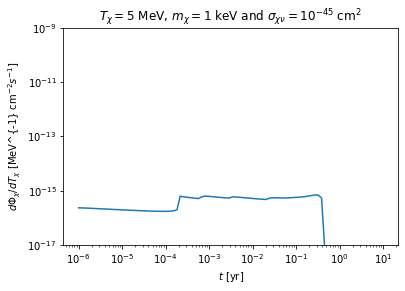

In [48]:
plt.plot(time_ls/yr2s,bdmflux_legacy)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t$ [yr]')
plt.ylabel(r'$d\Phi_\chi/dT_\chi$ [MeV^{-1} cm$^{-2} s^{-1}$]')
plt.title(r'$T_\chi = 5$ MeV, $m_\chi = 1$ keV and $\sigma_{\chi\nu}=10^{-45}$ cm$^2$')
plt.ylim(1e-17,1e-9)

In [62]:
Rstar = 8.5
Tx = 5
mx = 1e-3
mV = mx/3
theta_ls = np.logspace(-2,np.log10(np.pi/2),20)
phi_ls = np.linspace(0,2*np.pi,20)
bdmflux = []
integ = vegas.Integrator([[0, np.pi/2]])
time_ls = np.logspace(np.log10(yr2s)-3,np.log10(1000*yr2s),10)
i = 1
for t in time_ls:
    def f(x):
        theta = x[0]
        return 2*np.pi*get_BDMflux_theta(t,Tx,mx,mV,Rstar,theta,0,0)
        #if ~np.isnan(flux):
        #    return flux
        #else: return 0
    result = integ(f,nitn=10,neval=2000)
    bdmflux.append(result.mean)
    print(i,end='\r')
    i+=1

/Users/yenhsun/GitHub/SNnuBDM2/src/geometry.py:128: RuntimeWarning: divide by zero encountered in double_scalars
  cosIota = (Re**2 - ell2 - (d*np.cos(theta))**2)/(2*np.cos(theta)*np.sqrt(ell2)*d)
/Users/yenhsun/GitHub/SNnuBDM2/src/geometry.py:128: RuntimeWarning: invalid value encountered in sqrt
  cosIota = (Re**2 - ell2 - (d*np.cos(theta))**2)/(2*np.cos(theta)*np.sqrt(ell2)*d)
/Users/yenhsun/GitHub/SNnuBDM2/src/geometry.py:148: RuntimeWarning: invalid value encountered in sqrt
  rp2 = ell2*cosIota**2 + (np.sqrt(ell2)*sinIota - h*np.sin(phi))**2 + h**2*np.cos(phi)**2


/var/folders/qf/n6502vwn5yz_j_q3fyn7nt140000gn/T/ipykernel_63068/4157039656.py:12: RuntimeWarning: invalid value encountered in arccos
  psi = np.arccos(get_cosPsi(d,Rstar,theta))


Text(0.5, 1.0, '$T_\\chi = 5$ MeV, $m_\\chi = 1$ keV and $g_V=g_D=1$')

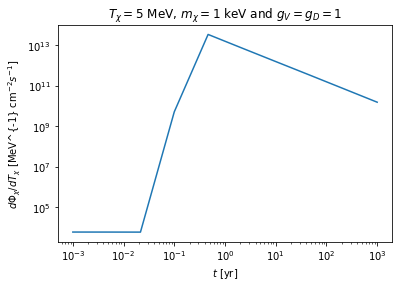

In [65]:
plt.plot(time_ls/yr2s,np.abs(bdmflux))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t$ [yr]')
plt.ylabel(r'$d\Phi_\chi/dT_\chi$ [MeV^{-1} cm$^{-2} s^{-1}$]')
plt.title(r'$T_\chi = 5$ MeV, $m_\chi = 1$ keV and $g_V=g_D=1$')
#plt.ylim(1e-17,1e-9)

In [64]:
bdmflux

[6006.253113160785,
 5993.278398273806,
 5961.098966021398,
 5135520633.6495695,
 -33795696248025.754,
 -7211816114310.219,
 -1552496730187.2654,
 -335998741537.66473,
 -71831904500.80574,
 -15324692032.103384]

In [12]:
get_Ev_cosPhi(5,5e-3,0.1)

(5.005260413636671, 0.050503352033445734, 'valid', 1)

In [7]:
get_rprime?

Signature: get_rprime(d, Rstar, Re, theta, phi, beta, tolerance=1e-10)
Docstring:
Calculate the distance from boosted point to GC r'

Input
------
d: the l.o.s distance d
Rstar: the distance between Earth and SN
Re: the distance between Earth and the GC
theta: the open-angle in rad
phi: the azimuth angle in rad
beta: the off-center angle in rad

Output
------
r': the distance r'
File:      ~/GitHub/SNnuBDM2/src/geometry.py
Type:      function


In [8]:
get_d?

Signature: get_d(t, vx, Rstar, theta)
Docstring:
Calculate the distance l.o.s d

Input
------
t: the arrival time of BDM at Earth relative to the first SN neutrino on the Earth
vx: BDM velocity in the unit of light speed
Rstar: the distance between Earth and SN
theta: the open-angle in rad

Output
------
d: the l.o.s
File:      ~/GitHub/SNnuBDM2/src/geometry.py
Type:      function


In [9]:
get_D?

Signature: get_D(d, Rstar, theta, is_square=False)
Docstring:
Calculate the distance between SN and boosted point D

Input
------
d: the l.o.s distance d
Rstar: the distance between Earth and SN
theta: the open-angle in rad
is_square: return the square of such distance, default is False

Output
------
D: the distance D
File:      ~/GitHub/SNnuBDM2/src/geometry.py
Type:      function


In [10]:
?get_cosPsi

Signature: get_cosPsi(d, Rstar, theta)
Docstring:
Get the cosine value of scattering angle cos(psi).
If we did it with law of cosine, then for the case of psi > pi/2,
it will always return pi - psi which cannot reflect the pratical
situation

Input
------
d: the l.o.s distance d
Rstar: the distance between Earth and SN
theta: the open-angle in rad

Output
------
psi: scattering angle in rad
File:      ~/GitHub/SNnuBDM2/src/geometry.py
Type:      function


In [9]:
get_BDMv?

Signature: get_BDMv(Tx, mx)
Docstring:
The BDM velocity in the unit of light speed

Input
------
Tx: DM kinetic energy
mx: DM mass

Output
------
vx: VDM velocity
File:      ~/GitHub/SNnuBDM2/src/crossSection.py
Type:      function
